# `fmri-08`: Multivariate pattern analysis (MVPA)
This demo introduces multivariate pattern analysis (MVPA) using one of the datasets that popularized the application of machine learning to fMRI. Specifically, we will use classification models (e.g. the support vector machine; SVM) to differentiate between spatially-distributed cortical response patterns corresponding to different object stimuli (e.g. faces, houses, etc). Rather than using a regression model to predict brain activity at each voxel from the stimulus/task (sometimes referred to as an "encoding" model), multivariate pattern classification models predict the stimulus or task from distributed patterns of brain activity (referred to as a "decoding" model).

In [1]:
import numpy as np
import nibabel as nib
import pandas as pd
import matplotlib.pyplot as plt

### Visual object recognition dataset
We'll demo multivariate pattern classification on the visual object recognition dataset from [Haxby et al., 2001](https://doi.org/10.1126/science.1063736). This study popularized machine learning in fMRI and spurred a debate about localized versus distributed representation in human brain activity. Participants were presented with images from 8 object categories (bottles, cats, chairs, faces, houses, scissors, scrambled images, and shoes) interspersed with periods of fixation (referred to as "rest" here). The TR in this study was 2.5 seconds. In a given run, a block of images from each of the 8 categories was presented one time. Each block was ~9 TRs long and contained multiple rapid presentations of images from a single category. A subject received 12 scanning runs. We'll focus on data from one subject for the purposes of this demo.

In [2]:
# Download Haxby 2001 data
from nilearn import datasets

# If you're on your local machine, change this path:
data_dir = '/jukebox/PNI-classes/students/NEU502/2021/nilearn-data'

haxby_dataset = datasets.fetch_haxby(data_dir=data_dir)

We'll need to extract certain attributes of the dataset, namely: the stimulus labels and the run labels. We'll exclude the the fixation TRs (the "rest" labels) from our analysis.

In [3]:
# Load in session metadata as pandas DataFrame
session = pd.read_csv(haxby_dataset.session_target[0], sep=" ")

# Extract stimuli and run labels for this subject
stimuli, runs = session['labels'].values, session['chunks'].values

# Create a boolean array indexing TRs containing a stimulus (non-rest)
task_trs = stimuli != 'rest'

# Get list of unique stimulus categories (excluding rest)
categories = [c for c in np.unique(stimuli) if c != 'rest']

In [4]:
# Make sure we have the same number of TRs for data and labels
from nilearn.image import index_img

func_file = haxby_dataset.func[0]

func_task = index_img(func_file, task_trs)

stimuli_task = stimuli[task_trs]
runs_task = runs[task_trs]

assert len(stimuli_task) == len(runs_task) == func_task.shape[-1]

Rather than applying classification analysis to the whole brain, we'll focus on a specifically on ventral temporal (VT) cortex due to it's role in visual object and category representation.

In [5]:
# Get the VT mask file and creater masker
from nilearn.input_data import NiftiMasker

mask_vt = haxby_dataset['mask_vt'][0]
masker_vt = NiftiMasker(mask_img=mask_vt, standardize=True)

### Model evaluation using cross-validation
To evaluate the quality of our classification model, we'll use a procedure called cross-validation. In this procedure, we train the model on a subset our data, then test the trained model on a left-out subset of data. This results in a cross-validation score per cross-validation fold. When running a within-subjects classification analysis, the most common approach is to use leave-one-run-out cross-validation. In the current example, the dataset has 12 independent scanning runs. In leave-one-run-out cross-validation, the model will be trained on each subset of 11 runs and tested on the left-out 12th run, resulting in 12 classification scores.

In [6]:
# Load sklearn's LeaveOneGroupOut cross-validation
from sklearn.model_selection import LeaveOneGroupOut

cv = LeaveOneGroupOut()

In [7]:
# Borrow a function from sklearn to visualize the cross-validation folds
def plot_cv_indices(cv, X, y, group, ax, n_splits, lw=10):
    """Create a sample plot for indices of a cross-validation object."""

    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y, groups=group)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(range(len(indices)), [ii + .5] * len(indices),
                   c=indices, marker='_', lw=lw, cmap=cmap_cv,
                   vmin=-.2, vmax=1.2)

    # Plot the data classes and groups at the end
    ax.scatter(range(len(X)), [ii + 1.5] * len(X),
               c=y, marker='_', lw=lw, cmap=cmap_data)

    ax.scatter(range(len(X)), [ii + 2.5] * len(X),
               c=group, marker='_', lw=lw, cmap=cmap_data)

    # Formatting
    yticklabels = list(range(n_splits)) + ['class', 'group']
    ax.set(yticks=np.arange(n_splits+2) + .5, yticklabels=yticklabels,
           xlabel='Sample index', ylabel="CV iteration",
           ylim=[n_splits+2.2, -.2], xlim=[0, len(X)])
    ax.set_title('{}'.format(type(cv).__name__), fontsize=15)
    return ax

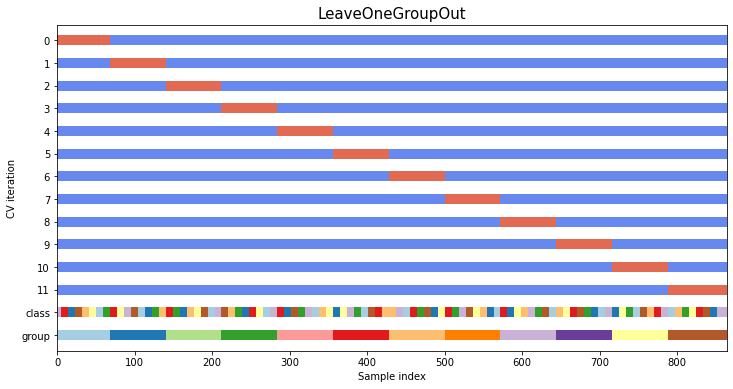

In [8]:
# Set up a couple variables for plotting
cmap_data = plt.cm.Paired
cmap_cv = plt.cm.coolwarm
stimuli_map = {c: i for i, c in enumerate(categories)}
stimuli_int = [stimuli_map[s] for s in stimuli_task]

fig, ax = plt.subplots(figsize=(12, 6))
plot_cv_indices(cv, masker_vt.fit_transform(func_task),
                stimuli_int, runs_task, ax, 12);

### Classification model
Next, we'll load in Nilearn's `Decoder`, which provides a shortcut interface to some common classification models. We'll start with a basic support vector classifier ('svc'). There are a variety of ways to evaluate classifier performance. We'll use classification accuracy because this is a standard in the field (although other performance metrics maybe better; e.g. `roc_au`).

In [9]:
# Import nilearn's Decoder for SVM with cross-validation
from nilearn.decoding import Decoder

decoder = Decoder(estimator='svc', cv=cv,
                  mask=masker_vt, scoring='accuracy')

In [10]:
# Fitting the decoder on the data across all CV folds
decoder.fit(func_task, stimuli_task, groups=runs_task)

# Get scores for each class and CV fold
scores = decoder.cv_scores_

In [11]:
# Print classification accuracy for each class
for category in categories:
    print(f"Mean classification accuracy for {category} "
          f"stimuli: {np.mean(scores[category]):.3f}")
print("Overall mean classification accuracy: "
      f"{np.mean([scores[c] for c in categories]):.3f}")

Mean classification accuracy for bottle stimuli: 0.554
Mean classification accuracy for cat stimuli: 0.664
Mean classification accuracy for chair stimuli: 0.631
Mean classification accuracy for face stimuli: 0.650
Mean classification accuracy for house stimuli: 0.697
Mean classification accuracy for scissors stimuli: 0.699
Mean classification accuracy for scrambledpix stimuli: 0.716
Mean classification accuracy for shoe stimuli: 0.631
Overall mean classification accuracy: 0.655


Rather than using Nilearn's convenient `Decoder` function, we can also use classifiers directly from scikit-learn. For example, here we'll recreate a similar model using scikit-learn's `LinearSVC`.

In [12]:
# Load in automated cross-validation and classifier
from sklearn.model_selection import cross_val_score
from sklearn.svm import LinearSVC

classifier = LinearSVC()

scores = cross_val_score(classifier,
                         masker_vt.fit_transform(func_task),
                         stimuli_task,
                         cv=cv,
                         groups=runs_task,
                         scoring="accuracy")

print(f"Overall mean classification accuracy: {np.mean(scores):.3f}")

/Users/snastase/miniconda3/envs/ctf/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/snastase/miniconda3/envs/ctf/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/snastase/miniconda3/envs/ctf/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/snastase/miniconda3/envs/ctf/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/snastase/miniconda3/envs/ctf/lib/python3.8/site-packages/skle

Overall mean classification accuracy: 0.666


/Users/snastase/miniconda3/envs/ctf/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


We can inspect classifier performance in more detail by visualizing the confusion matrix. Common metrics for quantifying classifer performance (e.g. accuracy, precision, AUROC) are summarizations of different aspects of the confusion matrix.

/Users/snastase/miniconda3/envs/ctf/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/snastase/miniconda3/envs/ctf/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/snastase/miniconda3/envs/ctf/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/snastase/miniconda3/envs/ctf/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/snastase/miniconda3/envs/ctf/lib/python3.8/site-packages/skle

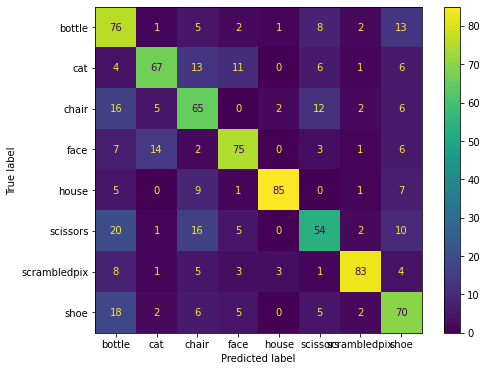

In [13]:
# Plot confusion matrix
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Re-fit model to explicitly get predicted labels
y_pred = cross_val_predict(classifier,
                           masker_vt.fit_transform(func_task),
                           stimuli_task,
                           cv=cv,
                           groups=runs_task)

# Create confusion matrix from true and predicted labels
cm = confusion_matrix(stimuli_task, y_pred)

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
ConfusionMatrixDisplay(cm, display_labels=categories).plot(ax=ax);

How "good" is our classification accuracy? Classification accuracy should be evaluated with respect to "chance" activity; i.e. the expected classification accuracy if the stimulus labels were randomly asigned. In a dataset with balanced class frequencies (i.e. samee number of samples per class), the chance accuracy is typically $1 / n$ where $n$ is the number of distinct classes. For the current dataset, the chance accuracy is $1/8 = .125$.

### Visualizing the weight vectors
Similarly to regression, training a classifier model yields coefficients (or "weights") assigned to each feature in the model. Unlike the GLM, in the decoding framework, the features of the model are voxels; thus, a weight is assigned to each voxel indicating it's importance for successful classification. We can visualize these weights on the brain. Note, however, that these weight vectors are more difficult to interpret than activation maps ([Haufe et al., 2014](https://doi.org/10.1016/j.neuroimage.2013.10.067)).

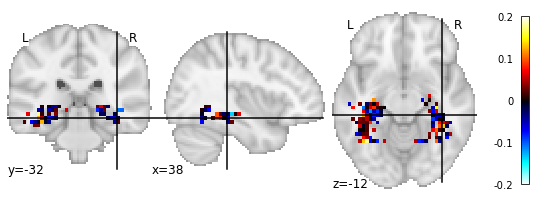

In [14]:
# Visualize the weight vector for the face class
from nilearn.plotting import plot_stat_map

cut_coords = (38, -32, -12)
plot_stat_map(decoder.coef_img_['face'], cut_coords=cut_coords)

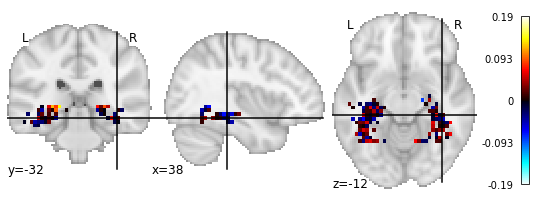

In [15]:
# Visualize the weight vector for the house class
cut_coords = (38, -32, -12)
plot_stat_map(decoder.coef_img_['house'], cut_coords=cut_coords)

### Accounting for the hemodynamic lag
So far, in the preceding analyses, we have simply tried to decode the current stimulus from response pattern at the corresponding TR. However, this does not take into account the fact that the peak BOLD response to a stimulus is delayed by several seconds. Here, we shift the stimulus labels by a 2-TR (5 seconds) delay to roughly account for the hemodynamic lag. (Note, however, that in a block design like this, perfect temporal alignment is not as critical as in an rapid event-related design.)

In [16]:
# Delay the stimulus labels by 2 TRs (5 seconds)
delay_trs = 2
stimuli_delayed = []
for run in np.unique(runs):
    stimuli_run = stimuli[runs == run]
    delayed_run = np.concatenate((['rest'] * delay_trs,
                                  stimuli_run))[:-delay_trs]
    stimuli_delayed.append(delayed_run)
stimuli_delayed = np.concatenate(stimuli_delayed)

# Re-splice task/rest TRs after delay
task_trs = stimuli_delayed != 'rest'

# Grab only stimulus TRs after delay
func_task = index_img(func_file, task_trs)
stimuli_task = stimuli_delayed[task_trs]
runs_task = runs[task_trs]

# Make sure we have the same number of TRs for data and labels
assert len(stimuli_task) == len(runs_task) == func_task.shape[-1]

In [17]:
# Re-run decoder with delay to account for HRF
decoder.fit(func_task, stimuli_task, groups=runs_task)

# Get scores for each class and CV fold
scores = decoder.cv_scores_

# Print classification accuracy for each class
for category in categories:
    print(f"Mean classification accuracy for {category} "
          f"stimuli: {np.mean(scores[category]):.3f}")
print("Overall mean classification accuracy: "
      f"{np.mean([scores[c] for c in categories]):.3f}")

/Users/snastase/miniconda3/envs/ctf/lib/python3.8/site-packages/nilearn/decoding/decoder.py:127: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


Mean classification accuracy for bottle stimuli: 0.567
Mean classification accuracy for cat stimuli: 0.647
Mean classification accuracy for chair stimuli: 0.646
Mean classification accuracy for face stimuli: 0.649
Mean classification accuracy for house stimuli: 0.630
Mean classification accuracy for scissors stimuli: 0.655
Mean classification accuracy for scrambledpix stimuli: 0.693
Mean classification accuracy for shoe stimuli: 0.612
Overall mean classification accuracy: 0.637


### First-level GLM prior to classification
In the previous analyses, we have fed each time point corresponding to a given stimulus class into the classifier. However, for some experimental designs, it may be more appropriate to first perform a GLM, then supply the classifier with the beta weights (i.e. coefficients) from the GLM. This reduces the number of samples (i.e. response patterns) for the classifier, but may result in cleaner samples. Here, we'll use Nilearn's `FirstLevelModel` to run a GLM separately for each run, then provide the resulting contrast maps to the classifier.

In [18]:
# Build first-level GLM for each run
from nilearn.glm.first_level import FirstLevelModel

tr = 2.0

events = {}
for run in np.unique(runs):
    stimuli_run = stimuli[runs == run]
    n_trs = len(stimuli_run)
    onset = tr * np.arange(n_trs)
    duration = np.full(n_trs, tr)
    
    events_all = pd.DataFrame(
        {'onset': onset, 'trial_type': stimuli_run, 'duration': duration})
    events[run] = events_all[events_all['trial_type'] != 'rest']

glm = FirstLevelModel(t_r=tr, hrf_model='spm',
                      mask_img=mask_vt,
                      drift_model='cosine',
                      high_pass=1/128,
                      standardize=True,
                      noise_model='ar1')

In [19]:
# Fit the model and collect beta maps
glm_maps = []
glm_categories = []
glm_runs = []

for run in np.unique(runs):
    func_run = index_img(func_file, runs == run)
    glm.fit(func_run, events=events[run])
    for category in categories:
        glm_maps.append(glm.compute_contrast(category))
        glm_categories.append(category)
        glm_runs.append(run)

In [20]:
# Visualize the GLM report
from nilearn.image import mean_img
from nilearn.reporting import make_glm_report

func_mean = mean_img(func_file)
make_glm_report(glm,
                contrasts=categories,
                bg_img=func_mean,
                threshold=0,
                height_control=None)

/Users/snastase/miniconda3/envs/ctf/lib/python3.8/site-packages/numpy/ma/core.py:2831: UserWarning: Warning: converting a masked element to nan.
  _data = np.array(data, dtype=dtype, copy=copy,


In [21]:
# Fitting the decoder on the GLM data across runs
decoder = Decoder(estimator='svc', cv=cv,
                  mask=mask_vt, scoring='accuracy',
                  standardize=False)

decoder.fit(glm_maps, glm_categories, groups=glm_runs)

# Get scores for each class and CV fold
scores = decoder.cv_scores_

# Print classification accuracy for each class
for category in categories:
    print(f"Mean classification accuracy for {category} "
          f"stimuli: {np.mean(scores[category]):.3f}")
print("Overall mean classification accuracy: "
      f"{np.mean([scores[c] for c in categories]):.3f}")

Mean classification accuracy for bottle stimuli: 0.833
Mean classification accuracy for cat stimuli: 0.823
Mean classification accuracy for chair stimuli: 0.917
Mean classification accuracy for face stimuli: 0.875
Mean classification accuracy for house stimuli: 0.917
Mean classification accuracy for scissors stimuli: 0.865
Mean classification accuracy for scrambledpix stimuli: 0.927
Mean classification accuracy for shoe stimuli: 0.833
Overall mean classification accuracy: 0.874


### Hyperparameter optimization using grid search
Most classification models have multiple hyperparameters that will affect performance; for example, in SVMs, the hyperparameter $C$ controls the width of the margin used when positioning the decision boundary. The best hyperparameter setting will vary from dataset to dataset. In order to chose the best hyperparameter(s) in an unbiased way, we can evaluate a variety of hyperarameter settings (referred to as a "grid") using cross-validation nested within each of our training samples. In our previous examples, this hyperparameter optimization was either performed under the hood, or the software's default hyperparameter was used. Here, we'll use a larger grid of settings for $C$ in hopes of improving classification performance.

In [22]:
# Create grid of C hyperparameter settings
param_grid = {'C': np.logspace(-8, 2, 11)}
print(f"C hyperparamater grid:\n {param_grid['C']}")

C hyperparamater grid:
 [1.e-08 1.e-07 1.e-06 1.e-05 1.e-04 1.e-03 1.e-02 1.e-01 1.e+00 1.e+01
 1.e+02]


In [23]:
# Fit classification model with hyperparameter grid
decoder = Decoder(estimator='svc', cv=cv,
                  mask=mask_vt, scoring='accuracy',
                  param_grid=param_grid,
                  standardize=False)
decoder.fit(glm_maps, glm_categories, groups=glm_runs)

# Get scores for each class and CV fold
scores = decoder.cv_scores_

# Print classification accuracy for each class
for category in categories:
    print(f"Mean classification accuracy for {category} "
          f"stimuli: {np.mean(scores[category]):.3f}")
print("Overall mean classification accuracy: "
      f"{np.mean([scores[c] for c in categories]):.3f}")

Mean classification accuracy for bottle stimuli: 0.885
Mean classification accuracy for cat stimuli: 0.875
Mean classification accuracy for chair stimuli: 0.938
Mean classification accuracy for face stimuli: 0.906
Mean classification accuracy for house stimuli: 0.927
Mean classification accuracy for scissors stimuli: 0.896
Mean classification accuracy for scrambledpix stimuli: 0.948
Mean classification accuracy for shoe stimuli: 0.875
Overall mean classification accuracy: 0.906


#### References
* Haufe, S., Meinecke, F., Görgen, K., Dähne, S., Haynes, J. D., Blankertz, B., & Bießmann, F. (2014). On the interpretation of weight vectors of linear models in multivariate neuroimaging. *NeuroImage*, *87*, 96-110. https://doi.org/10.1016/j.neuroimage.2013.10.067

* Haxby, J. V., Gobbini, M. I., Furey, M. L., Ishai, A., Schouten, J. L., & Pietrini, P. (2001). Distributed and overlapping representations of faces and objects in ventral temporal cortex. *Science*, *293*(5539), 2425–2430. https://doi.org/10.1126/science.1063736